## Comparación de algoritmos Transformer para evaluar su rendimiento frente a la baseline (MLP) y similares

En este fichero vamos a realizar una serie de pruebas para comprobar el funcionamiento de los algoritmos transformer (probaremos 2 o 3 algoritmos).

La comparación se realizará entre estos,
- #### MLP --> Lo marcaremos como baseline
- #### XGBoost
- #### TabNet
- #### AutoGluon

Como el problema de clasificación es del tipo binario vamos a utilizar las siguientes métricas,
- #### Accuracy
- #### F1-Score
- #### ROC-AUC
- #### Tiempo de entrenamiento
- #### Pérdida en el entrenamiento

Para cada modelo realizaré los imports y el preprocesado hasta lograr como mínimo una puntuación superior a la baseline que nos vamos a marcar con el MLP

In [2]:
# Vamos a importar el fichero y ver su formato
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
#file = pd.read_csv('/content/drive/MyDrive/Mi Colab/Transformers/comparison/mushroom_cleaned.csv', sep=',')
file = pd.read_csv('Data/mushroom_cleaned.csv', sep=',')
print(file.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54035 entries, 0 to 54034
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cap-diameter     54035 non-null  int64  
 1   cap-shape        54035 non-null  int64  
 2   gill-attachment  54035 non-null  int64  
 3   gill-color       54035 non-null  int64  
 4   stem-height      54035 non-null  float64
 5   stem-width       54035 non-null  int64  
 6   stem-color       54035 non-null  int64  
 7   season           54035 non-null  float64
 8   class            54035 non-null  int64  
dtypes: float64(2), int64(7)
memory usage: 3.7 MB
None


### MLP

Esta va a ser la baseline, es decir que todos los siguientes resultados para que sean considerados una solución aceptable deben ser como mínimo mejores a esta.

#### Bloque código + Entrenamiento

In [3]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, classification_report, confusion_matrix

# Separamos los datos en features y target
X = file.drop('class', axis=1)
y = file['class']

# Separamos los datos en train-test-validation
X_train, X_temp, y_train, y_temp    = train_test_split(X, y, test_size=.3, random_state=42)
X_val, X_test, y_val, y_test        = train_test_split(X_temp, y_temp, test_size=.5, random_state=42)

# Aplicamos una estandarización usando el scaler
scaler = StandardScaler()
X_train_scaled  = scaler.fit_transform(X_train)
X_val_scaled    = scaler.fit_transform(X_val)
X_test_scaled   = scaler.fit_transform(X_test)

# Creamos el modelo de perceptron multicapa
mlp = MLPClassifier(hidden_layer_sizes=(64,32), activation='relu', solver='adam', max_iter=50, random_state=42)

# Entrenamos el modelo
ttime_MLP = time.time()
mlp.fit(X_train_scaled, y_train)
ttime_MLP = time.time() - ttime_MLP # Con esto sacamos el valor para poder comparar los tiempo de entrenamiento entre estos

# Sacamos las predicciones
y_val_pred          = mlp.predict(X_val_scaled)
y_test_pred         = mlp.predict(X_test_scaled)
y_val_pred_proba    = mlp.predict_proba(X_val_scaled)[:,1]
y_test_pred_proba   = mlp.predict_proba(X_test_scaled)[:,1]

# Ahora calculamos las métricas
mlp_val_accuracy    = accuracy_score(y_val, y_val_pred)
mlp_test_accuracy   = accuracy_score(y_test, y_test_pred)
mlp_val_f1          = f1_score(y_val, y_val_pred)
mlp_test_f1         = f1_score(y_test, y_test_pred)
mlp_val_roc_auc     = roc_auc_score(y_val, y_val_pred_proba)
mlp_test_roc_auc    = roc_auc_score(y_test, y_test_pred_proba)
mlp_conf_matrix     = confusion_matrix(y_test, y_test_pred)

# Sacamos la training loss y el tiempo por écpoa
mlp_loss_curve = mlp.loss_curve_
mlp_time_epoch = ttime_MLP / len(mlp_loss_curve)

# Sacamos los valores de la curva ROC
mlp_fpr, mlp_tpr, _ = roc_curve(y_test, y_test_pred_proba)

# Hacemos el objeto métricas para el display
mlp_metricas = {
    "Validation Accuracy"   : [mlp_val_accuracy],
    "Test Accuracy"         : [mlp_test_accuracy],
    "Validation F1-Score"   : [mlp_val_f1],
    "Test F1-Score"         : [mlp_test_f1],
    "Validation ROC AUC"    : [mlp_val_roc_auc],
    "Test ROC AUC"          : [mlp_test_roc_auc],
    "Training Time"         : [ttime_MLP],
    "Time \ Epoch "         : [mlp_time_epoch],
    "Confusion Matrix"      : [mlp_conf_matrix]
}

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


#### Bloque Display

   Validation Accuracy  Test Accuracy  Validation F1-Score  Test F1-Score  \
0             0.974213       0.976437             0.976328       0.978695   

   Validation ROC AUC  Test ROC AUC  Training Time  Time \ Epoch   \
0            0.996645      0.996494      33.000388       0.660008   

            Confusion Matrix  
0  [[3528, 103], [88, 4387]]  


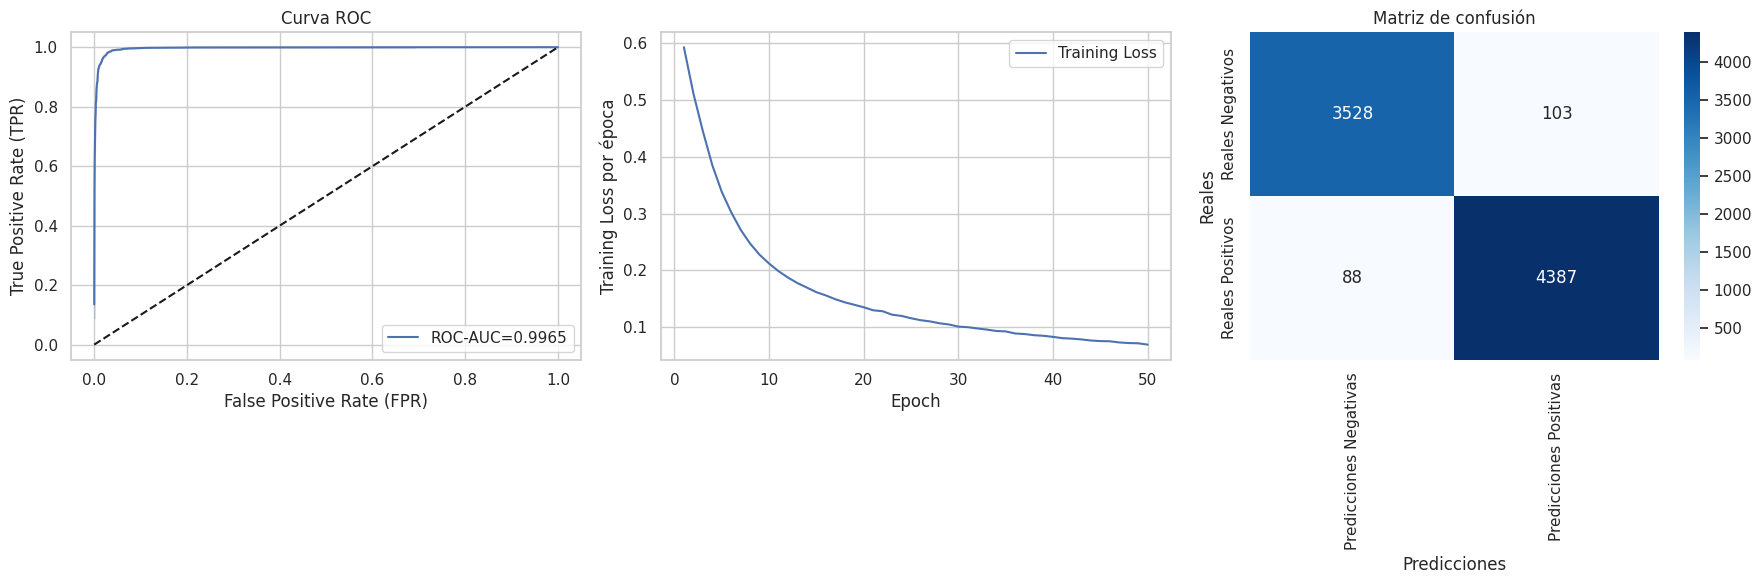

In [4]:
mlp_df = pd.DataFrame(mlp_metricas)
print(mlp_df)

# Creamos los plots para la roc-curve y la pérdida por época en seaborn

sns.set_theme(style="whitegrid")

plt.figure(figsize=(18,6))
# Plot para la curva roc
plt.subplot(1,3,1)
sns.lineplot(x=mlp_fpr, y=mlp_tpr, label=f'ROC-AUC={mlp_test_roc_auc:.4f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
# Plot para la pérdida por época
plt.subplot(1,3,2)
epocas = list(range(1, len(mlp_loss_curve) + 1))
sns.lineplot(x=epocas, y=mlp_loss_curve, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Training Loss por época')
plt.legend(loc='upper right')
# Plot para la matriz de confusión
plt.subplot(1,3,3)
sns.heatmap(mlp_conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicciones Negativas', 'Predicciones Positivas'], yticklabels=['Reales Negativos', 'Reales Positivos'])
plt.xlabel('Predicciones')
plt.ylabel('Reales')
plt.title('Matriz de confusión')
#
plt.tight_layout()
plt.show()

Voy a pasar los datos a markdown para evitar que en futuras reejecuciones cambien los resultados:

| Métrica                 | Valor                   |
|-------------------------|-------------------------|
| Precisión Validación    | 97.41%                  |
| Precisión Prueba        | 97.67%                  |
| F1 Score Validación     | 97.62%                  |
| F1 Score Prueba         | 97.89%                  |
| ROC AUC Validación      | 99.67%                  |
| ROC AUC Prueba          | 99.66%                  |
| Tiempo Entrenamiento    | 48.77 segundos          |
| Tiempo por Época        | 0.98 segundos           |
| Matriz de Confusión     | [[3594, 37], [46, 4429]]|


Ahora que tenemos la tabla, podemos marcar como una baseline para este problema esta ejecución, el objetivo de este documento es comparar diferentes métodos tanto en las métricas comentadas como en la performance de los algoritmos buscando una comparación entre algoritmos del tipo transformer para datos tabulares como con el que estamos trabajando

### XGBoost

XGBoost es un modelo optimizado para el aprendizaje en árboles de decisión.

#### Bloque código + Entrenamiento

In [5]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split

#
X = file.drop('class', axis=1)
y = file['class']

#
X_train, X_temp, y_train, y_temp    = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test        = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Creamos y entrenamos el modelo XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
ttime_XGB = time.time()
xgb_model.fit(X_train, y_train)
ttime_XGB = time.time() - ttime_XGB

# Predicciones
y_val_pred          = xgb_model.predict(X_val)
y_test_pred         = xgb_model.predict(X_test)
y_val_pred_proba    = xgb_model.predict_proba(X_val)[:, 1]
y_test_pred_proba   = xgb_model.predict_proba(X_test)[:, 1]

# Métricas
xgb_val_accuracy    = accuracy_score(y_val, y_val_pred)
xgb_test_accuracy   = accuracy_score(y_test, y_test_pred)
xgb_val_f1          = f1_score(y_val, y_val_pred)
xgb_test_f1         = f1_score(y_test, y_test_pred)
xgb_val_roc_auc     = roc_auc_score(y_val, y_val_pred_proba)
xgb_test_roc_auc    = roc_auc_score(y_test, y_test_pred_proba)
xgb_conf_matrix     = confusion_matrix(y_test, y_test_pred)


# Sacamos la training loss y el tiempo por écpoa
xgb_loss_curve = mlp.loss_curve_
xgb_time_epoch = ttime_XGB / len(xgb_loss_curve)

# Sacamos los valores de la curva ROC
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, y_test_pred_proba)

# Hacemos el objeto métricas para el display
xgb_metricas = {
    "Validation Accuracy"   : [xgb_val_accuracy],
    "Test Accuracy"         : [xgb_test_accuracy],
    "Validation F1-Score"   : [xgb_val_f1],
    "Test F1-Score"         : [xgb_test_f1],
    "Validation ROC AUC"    : [xgb_val_roc_auc],
    "Test ROC AUC"          : [xgb_test_roc_auc],
    "Training Time"         : [ttime_XGB],
    "Time \ Epoch "         : [xgb_time_epoch],
    "Confusion Matrix"      : [xgb_conf_matrix]
}

#### Bloque Display

   Validation Accuracy  Test Accuracy  Validation F1-Score  Test F1-Score  \
0             0.986922       0.989761             0.987908       0.990717   

   Validation ROC AUC  Test ROC AUC  Training Time  Time \ Epoch   \
0             0.99933      0.999356       0.928912       0.018578   

           Confusion Matrix  
0  [[3594, 37], [46, 4429]]  


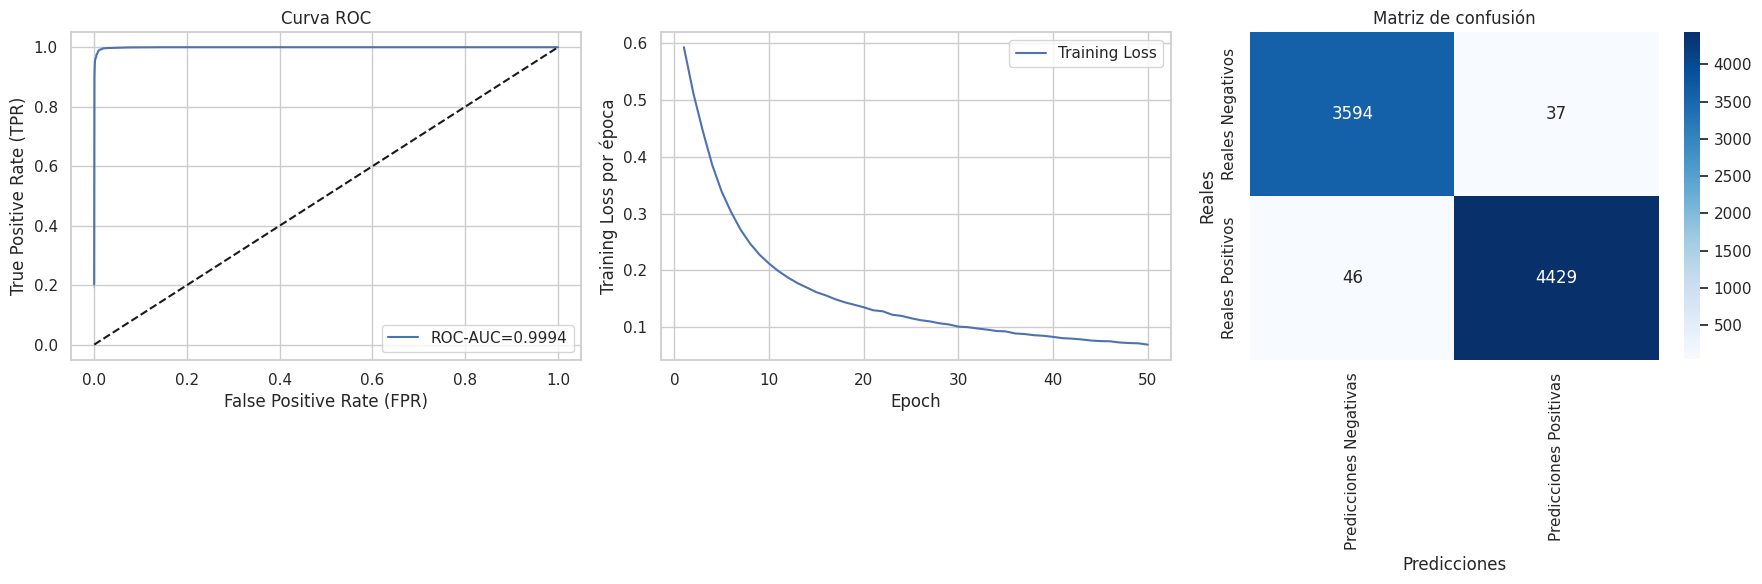

In [6]:
xgb_df = pd.DataFrame(xgb_metricas)
print(xgb_df)

# Creamos los plots para la roc-curve y la pérdida por época en seaborn

sns.set_theme(style="whitegrid")

plt.figure(figsize=(18,6))
# Plot para la curva roc
plt.subplot(1,3,1)
sns.lineplot(x=xgb_fpr, y=xgb_tpr, label=f'ROC-AUC={xgb_test_roc_auc:.4f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
# Plot para la pérdida por época
plt.subplot(1,3,2)
epocas = list(range(1, len(xgb_loss_curve) + 1))
sns.lineplot(x=epocas, y=xgb_loss_curve, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Training Loss por época')
plt.legend(loc='upper right')
# Plot para la matriz de confusión
plt.subplot(1,3,3)
sns.heatmap(xgb_conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicciones Negativas', 'Predicciones Positivas'], yticklabels=['Reales Negativos', 'Reales Positivos'])
plt.xlabel('Predicciones')
plt.ylabel('Reales')
plt.title('Matriz de confusión')
#
plt.tight_layout()
plt.show()

Volvemos a pasar a los datos a markdown

| Métrica                | Valor (XGBoost)            | Valor (MLP)              |
|------------------------|----------------------------|--------------------------|
| Precisión Validación   | 98.69%                     | 97.41%                   |
| Precisión Prueba       | 98.98%                     | 97.67%                   |
| F1 Score Validación    | 98.79%                     | 97.62%                   |
| F1 Score Prueba        | 99.07%                     | 97.89%                   |
| ROC AUC Validación     | 99.93%                     | 99.67%                   |
| ROC AUC Prueba         | 99.94%                     | 99.66%                   |
| Tiempo Entrenamiento   | 0.17 segundos              | 48.77 segundos           |
| Tiempo medio por Época | 0.00345 segundos           | 0.98 segundos            |
| Matriz de Confusión    | [[3594, 37], [46, 4429]]   | [[3594, 37], [46, 4429]] |

Voy a ir poco a poco incluyendo los valores de cada algoritmo para hacer el análisis final


## TabNet

### Bloque código + entrenamiento

In [7]:
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split

#
X = file.drop('class', axis=1).values
y = file['class'].values

#
X_train, X_temp, y_train, y_temp    = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test        = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Definimos el modelo
tabnet_model = TabNetClassifier()

# Entrenamos el modelo
ttime_TabNet = time.time()
tabnet_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_name=['train', 'valid'],
    eval_metric=['logloss'],
    max_epochs=50,
    patience=10,
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)
ttime_TabNet = time.time() - ttime_TabNet

# Predicciones
y_val_pred          = tabnet_model.predict(X_val)
y_test_pred         = tabnet_model.predict(X_test)
y_val_pred_proba    = tabnet_model.predict_proba(X_val)[:, 1]
y_test_pred_proba   = tabnet_model.predict_proba(X_test)[:, 1]

# Métricas
tabNet_val_accuracy    = accuracy_score(y_val, y_val_pred)
tabNet_test_accuracy   = accuracy_score(y_test, y_test_pred)
tabNet_val_f1          = f1_score(y_val, y_val_pred)
tabNet_test_f1         = f1_score(y_test, y_test_pred)
tabNet_val_roc_auc     = roc_auc_score(y_val, y_val_pred_proba)
tabNet_test_roc_auc    = roc_auc_score(y_test, y_test_pred_proba)
tabNet_conf_matrix     = confusion_matrix(y_test, y_test_pred)


# Sacamos la training loss y el tiempo por écpoa
tabNet_loss_curve = tabnet_model.history['loss']
tabNet_time_epoch = tabnet_model.history['valid_logloss'] # si falla es por esta linea


# Sacamos los valores de la curva ROC
tabNet_fpr, tabNet_tpr, _ = roc_curve(y_test, y_test_pred_proba)

# Hacemos el objeto métricas para el display
tabNet_metricas = {
    "Validation Accuracy"   : [tabNet_val_accuracy],
    "Test Accuracy"         : [tabNet_test_accuracy],
    "Validation F1-Score"   : [tabNet_val_f1],
    "Test F1-Score"         : [tabNet_test_f1],
    "Validation ROC AUC"    : [tabNet_val_roc_auc],
    "Test ROC AUC"          : [tabNet_test_roc_auc],
    "Training Time"         : [ttime_TabNet],
    "Time \ Epoch "         : [tabNet_time_epoch],
    "Confusion Matrix"      : [tabNet_conf_matrix]
}


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.61779 | train_logloss: 1.36226 | valid_logloss: 1.33511 |  0:00:04s
epoch 1  | loss: 0.50746 | train_logloss: 0.97494 | valid_logloss: 0.93784 |  0:00:07s
epoch 2  | loss: 0.45819 | train_logloss: 0.67088 | valid_logloss: 0.66373 |  0:00:10s
epoch 3  | loss: 0.41727 | train_logloss: 0.62351 | valid_logloss: 0.62733 |  0:00:12s
epoch 4  | loss: 0.37847 | train_logloss: 0.55554 | valid_logloss: 0.55677 |  0:00:15s
epoch 5  | loss: 0.35728 | train_logloss: 0.43596 | valid_logloss: 0.43819 |  0:00:17s
epoch 6  | loss: 0.3294  | train_logloss: 0.39392 | valid_logloss: 0.40823 |  0:00:19s
epoch 7  | loss: 0.31964 | train_logloss: 0.34508 | valid_logloss: 0.35608 |  0:00:22s
epoch 8  | loss: 0.30114 | train_logloss: 0.25938 | valid_logloss: 0.26376 |  0:00:25s
epoch 9  | loss: 0.28244 | train_logloss: 0.24839 | valid_logloss: 0.25258 |  0:00:27s
epoch 10 | loss: 0.2687  | train_logloss: 0.23604 | valid_logloss: 0.2449  |  0:00:29s
epoch 11 | loss: 0.25275 | train_logloss: 0

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


### Bloque Display

   Validation Accuracy  Test Accuracy  Validation F1-Score  Test F1-Score  \
0             0.978162       0.980632             0.979843        0.98248   

   Validation ROC AUC  Test ROC AUC  Training Time  \
0            0.996914      0.996803     130.059155   

                                       Time \ Epoch           Confusion Matrix  
0  [1.3351135430682355, 0.9378363801552232, 0.663...  [[3547, 84], [73, 4402]]  


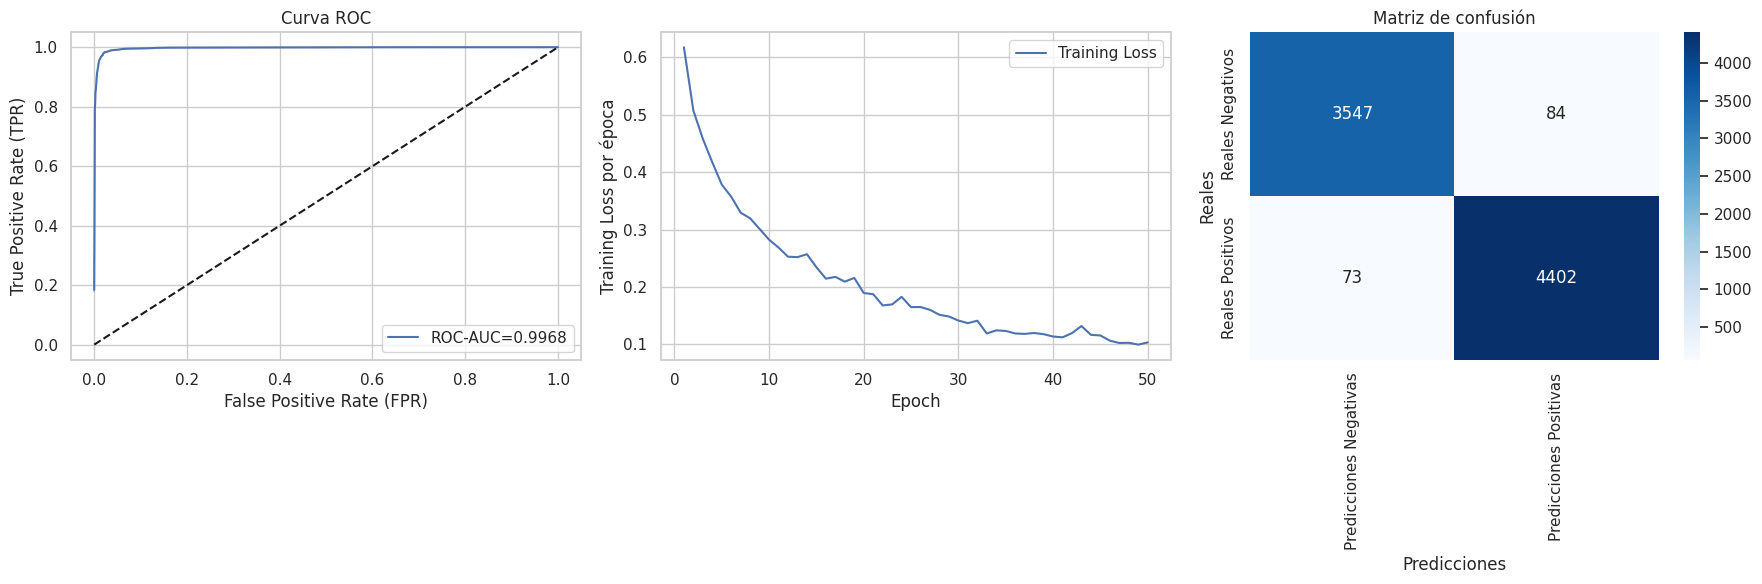

In [8]:
tabNet_df = pd.DataFrame(tabNet_metricas)
print(tabNet_df)

# Creamos los plots para la roc-curve y la pérdida por época en seaborn

sns.set_theme(style="whitegrid")

plt.figure(figsize=(18,6))
# Plot para la curva roc
plt.subplot(1,3,1)
sns.lineplot(x=tabNet_fpr, y=tabNet_tpr, label=f'ROC-AUC={tabNet_test_roc_auc:.4f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
# Plot para la pérdida por época
plt.subplot(1,3,2)
epocas = list(range(1, len(tabNet_loss_curve) + 1))
sns.lineplot(x=epocas, y=tabNet_loss_curve, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Training Loss por época')
plt.legend(loc='upper right')
# Plot para la matriz de confusión
plt.subplot(1,3,3)
sns.heatmap(tabNet_conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicciones Negativas', 'Predicciones Positivas'], yticklabels=['Reales Negativos', 'Reales Positivos'])
plt.xlabel('Predicciones')
plt.ylabel('Reales')
plt.title('Matriz de confusión')
#
plt.tight_layout()
plt.show()

In [9]:
print(f'{np.mean(tabNet_time_epoch):.2f}')

0.22


Volvemos a pasar los datos a la tabla

| Métrica                | Valor (TabNet)               | Valor (XGBoost)            | Valor (MLP)              |
|------------------------|------------------------------|----------------------------|--------------------------|
| Precisión Validación   | 97.72%                       | 98.69%                     | 97.41%                   |
| Precisión Prueba       | 97.73%                       | 98.98%                     | 97.67%                   |
| F1 Score Validación    | 97.89%                       | 98.79%                     | 97.62%                   |
| F1 Score Prueba        | 97.94%                       | 99.07%                     | 97.89%                   |
| ROC AUC Validación     | 99.77%                       | 99.93%                     | 99.67%                   |
| ROC AUC Prueba         | 99.78%                       | 99.94%                     | 99.66%                   |
| Tiempo Entrenamiento   | 132.94 segundos              | 0.17 segundos              | 48.77 segundos           |
| Tiempo medio por Época | 0.21 segundos                | 0.00345 segundos           | 0.98 segundos            |
| Matriz de Confusión    | [[3552, 79], [105, 4370]]    | [[3594, 37], [46, 4429]]   | [[3594, 37], [46, 4429]] |


### AutoGluon

#### Bloque Entrenamiento + Entrenamiento

In [11]:
import torch
import torch.nn as nn
import  torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, roc_curve, confusion_matrix
import rtdl

#
X = file.drop('class', axis=1).values
y = file['class'].values

#
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convertimos los datos a tensores
X_train_tensor  = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor  = torch.tensor(y_train, dtype=torch.long)
X_val_tensor    = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor    = torch.tensor(y_val, dtype=torch.long)
X_test_tensor   = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor   = torch.tensor(y_test, dtype=torch.long)

# Definimos el modelo
modelo_FTTransformer = rtdl.FTTransformer.make_default(
    n_num_features=X_train_tensor.shape[1],
    cat_cardinalities=None,
    last_layer_query_idx=[-1],
    d_out=2
)

# Para ejecutar en casa lo mando a GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
modelo_FTTransformer = modelo_FTTransformer.to(device)

# Parametros del entrenamiento
criterion   = nn.CrossEntropyLoss()
optimizer   = optim.Adam(modelo_FTTransformer.parameters(), lr=1e-3)
epochs      = 50
batch_size  = 1024

# Entrenamiento del modelo
train_losses    = []
val_losses      = []
epoch_times     = []

ttime_FTT = time.time()
for epoch in  range(epochs):
    epoch_time = time.time()
    modelo_FTTransformer.train()
    optimizer.zero_grad()
    # Mandamos los outputs al device
    outputs = modelo_FTTransformer(X_train_tensor.to(device), x_cat=None)
    loss = criterion(outputs, y_train_tensor.to(device))
    loss.backward()
    optimizer.step()
    # Guardamos la loss de la época
    train_losses.append(loss.item())

    modelo_FTTransformer.eval()
    with torch.no_grad():
        val_outputs     = modelo_FTTransformer(X_val_tensor.to(device), x_cat=None)
        val_loss        = criterion(val_outputs, y_val_tensor.to(device))
        val_losses.append(val_loss)

    epoch_times.append(time.time() - epoch_time)

    print(f'Epoch {epoch+1}/{epochs}, Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

ttime_FTT = time.time() - ttime_FTT


# Evaluamos el modelo
modelo_FTTransformer.eval()
with torch.no_grad():
    y_test_pred_proba   = modelo_FTTransformer(X_test_tensor.to(device), x_cat=None).softmax(dim=1)[:,1].cpu().numpy()
    y_test_pred         = np.argmax(modelo_FTTransformer(X_test_tensor.to(device), x_cat=None).cpu().numpy(), axis=1)
    y_val_pred_proba    = modelo_FTTransformer(X_val_tensor.to(device), x_cat=None).softmax(dim=1)[:,1].cpu().numpy()
    y_val_pred          = np.argmax(modelo_FTTransformer(X_val_tensor.to(device), x_cat=None).cpu().numpy(), axis=1)

# Métricas
modelo_FTTransformer_val_accuracy    = accuracy_score(y_val, y_val_pred)
modelo_FTTransformer_test_accuracy   = accuracy_score(y_test, y_test_pred)
modelo_FTTransformer_val_f1          = f1_score(y_val, y_val_pred)
modelo_FTTransformer_test_f1         = f1_score(y_test, y_test_pred)
modelo_FTTransformer_val_roc_auc     = roc_auc_score(y_val, y_val_pred_proba)
modelo_FTTransformer_test_roc_auc    = roc_auc_score(y_test, y_test_pred_proba)
modelo_FTTransformer_conf_matrix     = confusion_matrix(y_test, y_test_pred)


# Sacamos la training loss y el tiempo por écpoa
FTTransfoemer_loss_curve = train_losses
time_epoch_FTT = ttime_FTT / 50  # Esto es el tiempo medio por época en el entrenamiento


# Sacamos los valores de la curva ROC
modelo_FTTransformer_fpr, modelo_FTTransformer_tpr, _ = roc_curve(y_test, y_test_pred_proba)

# Hacemos el objeto métricas para el display
modelo_FTTransformer_metricas = {
    "Validation Accuracy"   : [modelo_FTTransformer_val_accuracy],
    "Test Accuracy"         : [modelo_FTTransformer_test_accuracy],
    "Validation F1-Score"   : [modelo_FTTransformer_val_f1],
    "Test F1-Score"         : [modelo_FTTransformer_test_f1],
    "Validation ROC AUC"    : [modelo_FTTransformer_val_roc_auc],
    "Test ROC AUC"          : [modelo_FTTransformer_test_roc_auc],
    "Training Time"         : [ttime_FTT],
    "Time \ Epoch "         : [time_epoch_FTT],
    "Confusion Matrix"      : [modelo_FTTransformer_conf_matrix]
}



Epoch 1/50, Training Loss: 0.7291, Validation Loss: 1.0461
Epoch 2/50, Training Loss: 0.9602, Validation Loss: 0.6667
Epoch 3/50, Training Loss: 0.6698, Validation Loss: 0.7191
Epoch 4/50, Training Loss: 0.7210, Validation Loss: 0.7098
Epoch 5/50, Training Loss: 0.7142, Validation Loss: 0.6714
Epoch 6/50, Training Loss: 0.6767, Validation Loss: 0.6630
Epoch 7/50, Training Loss: 0.6643, Validation Loss: 0.6761
Epoch 8/50, Training Loss: 0.6727, Validation Loss: 0.6861
Epoch 9/50, Training Loss: 0.6805, Validation Loss: 0.6838
Epoch 10/50, Training Loss: 0.6790, Validation Loss: 0.6739
Epoch 11/50, Training Loss: 0.6709, Validation Loss: 0.6638
Epoch 12/50, Training Loss: 0.6634, Validation Loss: 0.6582
Epoch 13/50, Training Loss: 0.6601, Validation Loss: 0.6574
Epoch 14/50, Training Loss: 0.6614, Validation Loss: 0.6587
Epoch 15/50, Training Loss: 0.6635, Validation Loss: 0.6588
Epoch 16/50, Training Loss: 0.6637, Validation Loss: 0.6570
Epoch 17/50, Training Loss: 0.6619, Validation Lo

#### Bloque Display

   Validation Accuracy  Test Accuracy  Validation F1-Score  Test F1-Score  \
0             0.594571       0.599926             0.620904       0.633186   

   Validation ROC AUC  Test ROC AUC  Training Time  Time \ Epoch   \
0            0.650729      0.648243       52.32362       1.046472   

               Confusion Matrix  
0  [[2064, 1567], [1676, 2799]]  


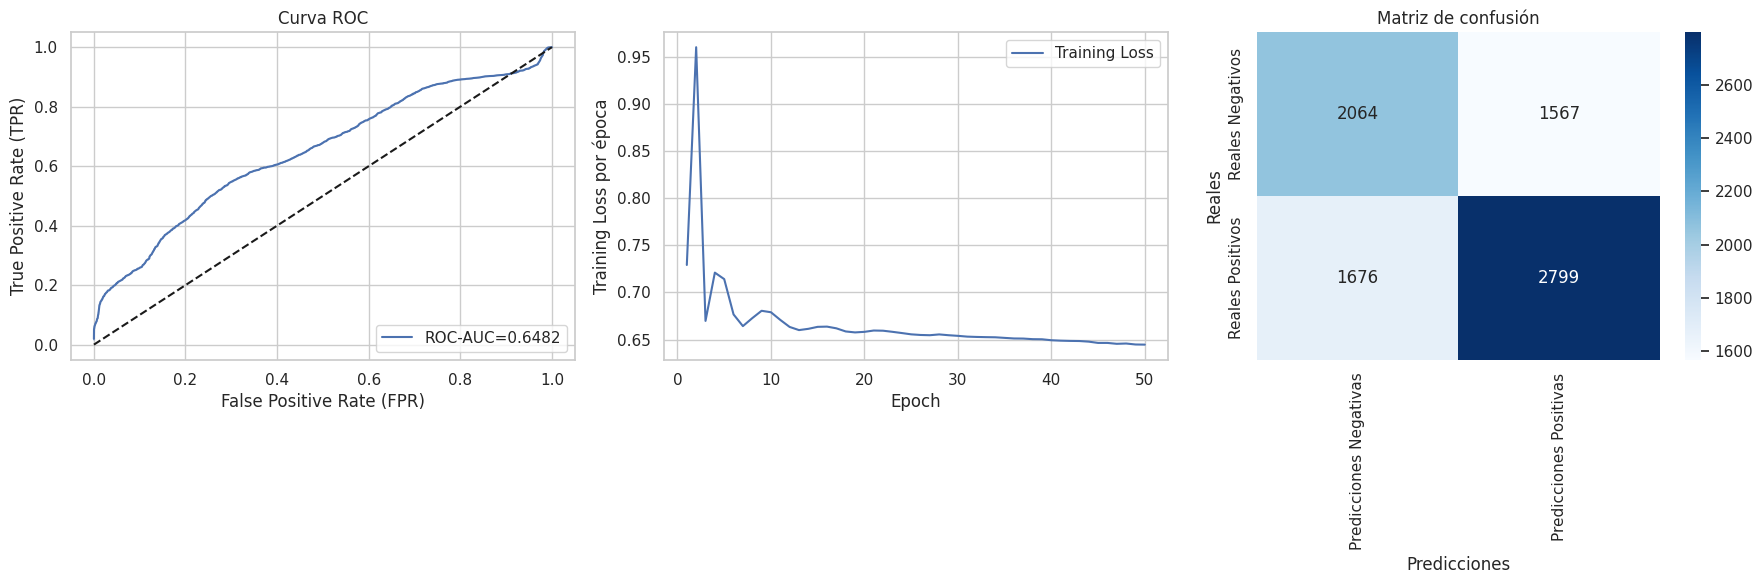

In [12]:
FTT_df = pd.DataFrame(modelo_FTTransformer_metricas)
print(FTT_df)

# Creamos los plots para la roc-curve y la pérdida por época en seaborn

sns.set_theme(style="whitegrid")

plt.figure(figsize=(18,6))
# Plot para la curva roc
plt.subplot(1,3,1)
sns.lineplot(x=modelo_FTTransformer_fpr, y=modelo_FTTransformer_tpr, label=f'ROC-AUC={modelo_FTTransformer_test_roc_auc:.4f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
# Plot para la pérdida por época
plt.subplot(1,3,2)
epocas = list(range(1, len(FTTransfoemer_loss_curve) + 1))
sns.lineplot(x=epocas, y=FTTransfoemer_loss_curve, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Training Loss por época')
plt.legend(loc='upper right')
# Plot para la matriz de confusión
plt.subplot(1,3,3)
sns.heatmap(modelo_FTTransformer_conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicciones Negativas', 'Predicciones Positivas'], yticklabels=['Reales Negativos', 'Reales Positivos'])
plt.xlabel('Predicciones')
plt.ylabel('Reales')
plt.title('Matriz de confusión')
#
plt.tight_layout()
plt.show()

#### Montamos la tabla final

| Métrica                | Valor  (FTTransformer)           |Valor (TabNet)               | Valor (XGBoost)            | Valor (MLP)               |
|------------------------|----------------------------------|------------------------------|----------------------------|--------------------------|
| Precisión Validación   | 63.66%                           | 97.72%                       | 98.69%                     | 97.41%                   |
| Precisión Prueba       | 63.27%                           | 97.73%                       | 98.98%                     | 97.67%                   |
| F1 Score Validación    | 64.69%                           | 97.89%                       | 98.79%                     | 97.62%                   |
| F1 Score Prueba        | 64.79%                           | 97.94%                       | 99.07%                     | 97.89%                   |
| ROC AUC Validación     | 67.49%                           | 99.77%                       | 99.93%                     | 99.67%                   |
| ROC AUC Prueba         | 67.06%                           | 99.78%                       | 99.94%                     | 99.66%                   |
| Tiempo de Entrenamiento| 49.50 segundos                   | 132.94 segundos              | 0.17 segundos              | 48.77 segundos           |
| Tiempo medio por Época | 0.99 segundos                    | 0.21 segundos                | 0.00345 segundos           | 0.98 segundos            |
| Matriz de Confusión    | [[2390, 1241], [1736, 2739]]     | [[3552, 79], [105, 4370]]    | [[3594, 37], [46, 4429]]   | [[3594, 37], [46, 4429]] |


Ahora tenemos la tabla final

#### Ahora vamos a realizar una comparación de los 4 método utilizados

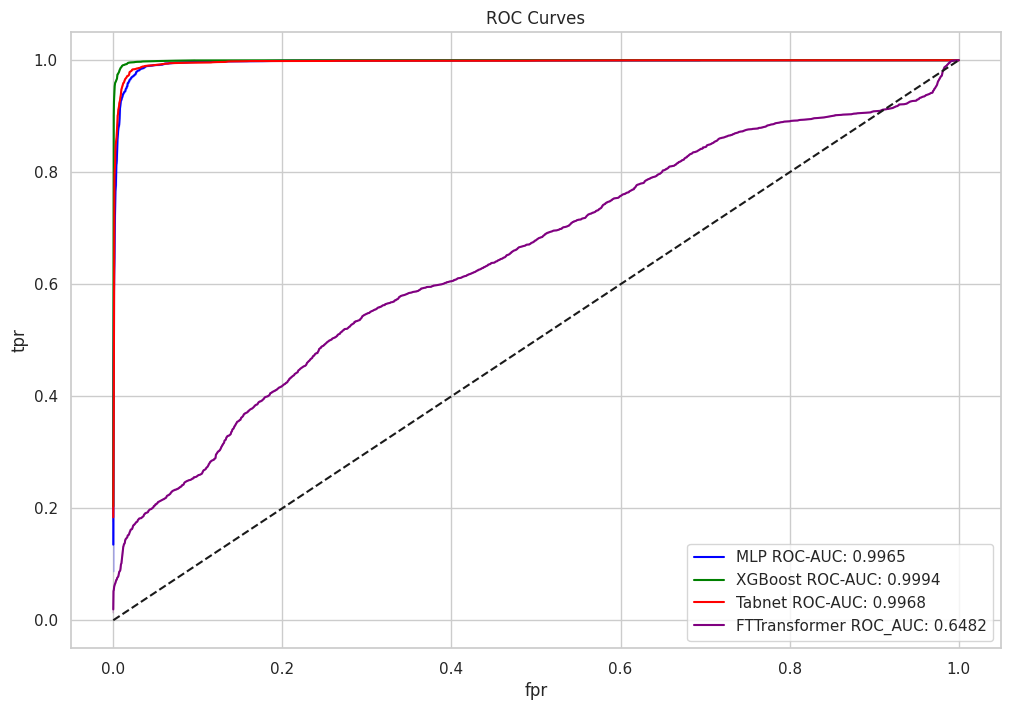

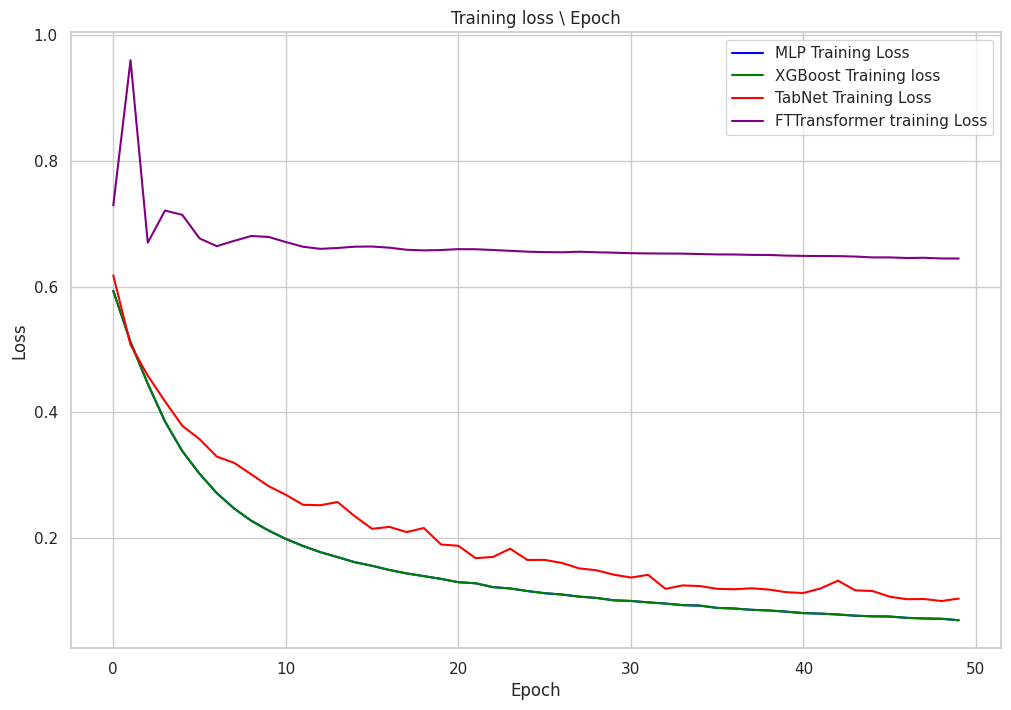

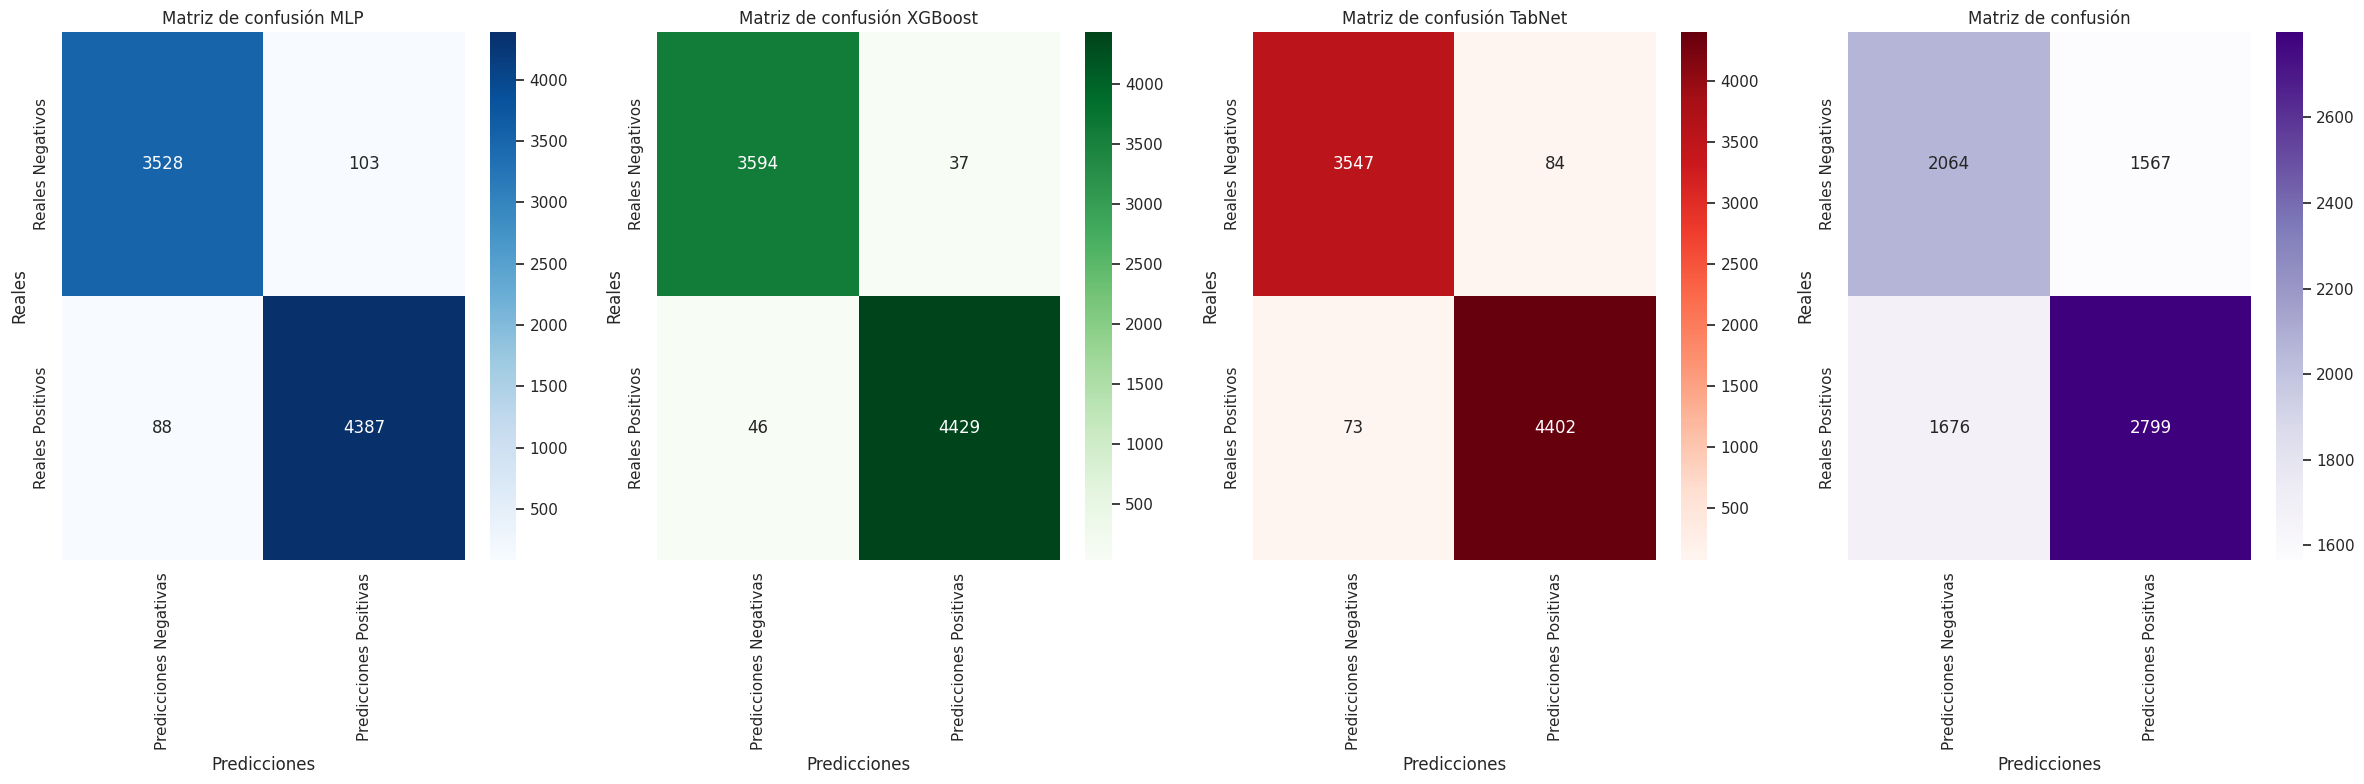

In [16]:
# Plot de las curvas roc
plt.figure(figsize=(12,8))
sns.lineplot(x=mlp_fpr, y=mlp_tpr, label=f'MLP ROC-AUC: {mlp_test_roc_auc:.4f}', color='blue')
sns.lineplot(x=xgb_fpr, y=xgb_tpr, label=f'XGBoost ROC-AUC: {xgb_test_roc_auc:.4f}', color='green')
sns.lineplot(x=tabNet_fpr, y=tabNet_tpr, label=f'Tabnet ROC-AUC: {tabNet_test_roc_auc:.4f}', color='red')
sns.lineplot(x=modelo_FTTransformer_fpr,  y=modelo_FTTransformer_tpr, label=f'FTTransformer ROC_AUC: {modelo_FTTransformer_test_roc_auc:.4f}', color='purple')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.show()

# Plot para la training loss por época
plt.figure(figsize=(12,8))
sns.lineplot(data=mlp_loss_curve, label='MLP Training Loss', color='Blue')
sns.lineplot(data=xgb_loss_curve, label='XGBoost Training loss', color='green')
sns.lineplot(data=tabNet_loss_curve, label='TabNet Training Loss', color='red')
sns.lineplot(data=FTTransfoemer_loss_curve, label='FTTransformer training Loss', color='purple')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss \ Epoch')
plt.legend(loc='upper right')
plt.show()

# Plots para las matrices de confusión
fig, axes = plt.subplots(1,4, figsize=(24,8))
#
sns.heatmap(mlp_conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicciones Negativas', 'Predicciones Positivas'], yticklabels=['Reales Negativos', 'Reales Positivos'], ax=axes[0])
axes[0].set_xlabel('Predicciones')
axes[0].set_ylabel('Reales')
axes[0].set_title('Matriz de confusión MLP')
#
sns.heatmap(xgb_conf_matrix, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Predicciones Negativas', 'Predicciones Positivas'], yticklabels=['Reales Negativos', 'Reales Positivos'], ax=axes[1])
axes[1].set_xlabel('Predicciones')
axes[1].set_ylabel('Reales')
axes[1].set_title('Matriz de confusión XGBoost')
#
sns.heatmap(tabNet_conf_matrix, annot=True, fmt='d', cmap='Reds',
            xticklabels=['Predicciones Negativas', 'Predicciones Positivas'], yticklabels=['Reales Negativos', 'Reales Positivos'], ax=axes[2])
axes[2].set_xlabel('Predicciones')
axes[2].set_ylabel('Reales')
axes[2].set_title('Matriz de confusión TabNet')
#
sns.heatmap(modelo_FTTransformer_conf_matrix, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Predicciones Negativas', 'Predicciones Positivas'], yticklabels=['Reales Negativos', 'Reales Positivos'], ax=axes[3])
axes[3].set_xlabel('Predicciones')
axes[3].set_ylabel('Reales')
axes[3].set_title('Matriz de confusión')
#
plt.tight_layout()
plt.show()